In [1]:
import pandas as pd
import ase
from ase.io.cif import read_cif
from ase.db import connect

structs_train = []
props_train = []

structs_val = []
props_val = []

structs_test = []
props_test = []


In [2]:
import json

with open('train_ids_CGCNN.json') as f:
    train_ids = json.load(f)

with open('val_ids_CGCNN.json') as f:
    val_ids = json.load(f)

with open('test_ids_CGCNN.json') as f:
    test_ids = json.load(f)
    

In [3]:
#print(train_ids)

train_ids_num = {}

for idx in train_ids:
    train_ids_num[int(idx[14:])] = 1
    
    
val_ids_num = {}

for idx in val_ids:
    val_ids_num[int(idx[14:])] = 1
    
test_ids_num = {}

for idx in test_ids:
    test_ids_num[int(idx[14:])] = 1

In [4]:
db_name = "reference_data.db"
db = connect(db_name)
concs = []
energies = []
i = 0
for row in db.select():
    
    atoms = row.toatoms()
    
    if i in train_ids_num:
        structs_train.append(atoms)
        prop = {'energy': row.mixing_energy}
        props_train.append(prop)
        
    elif i in val_ids_num:
        structs_val.append(atoms)
        prop = {'energy': row.mixing_energy}
        props_val.append(prop)
        
    elif i in test_ids_num:
        structs_test.append(atoms)
        prop = {'energy': row.mixing_energy}
        props_test.append(prop)
        
    else:
        print("ERROR")
        print(i)
    
    i+=1
    


ERROR
178


In [5]:
print(len(structs_train))
print(len(structs_val))
print(len(structs_test))


500
62
62


In [6]:
import os


In [7]:
from schnetpack import AtomsData

db_name = "./schnet_train_dataset.db"
db = connect(db_name)

train_dataset = AtomsData('./schnet_train_dataset.db', available_properties=['energy'])
train_dataset.add_systems(structs_train, props_train)

In [8]:
db_name = "./schnet_val_dataset.db"
db = connect(db_name)

val_dataset = AtomsData('./schnet_val_dataset.db', available_properties=['energy'])
val_dataset.add_systems(structs_val, props_val)

db_name = "./schnet_test_dataset.db"
db = connect(db_name)

test_dataset = AtomsData('./schnet_test_dataset.db', available_properties=['energy'])
test_dataset.add_systems(structs_test, props_test)

In [293]:
import schnetpack as spk

model_dir = './AgPd_Schnet'
if not os.path.exists('AgPd_Schnet'):
    os.makedirs(model_dir)

In [294]:
train = train_dataset
val = val_dataset
test = test_dataset

In [295]:
print(len(train))
print(len(val))
print(len(test))

500
62
62


In [296]:
train_loader = spk.AtomsLoader(train, batch_size=50, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=62)

In [297]:
means, stddevs = train_loader.get_statistics("energy")

In [298]:
schnet = spk.representation.SchNet(
    n_atom_basis=50, n_filters=30, n_gaussians=30, n_interactions=5,
    cutoff=5., cutoff_network=spk.nn.cutoff.CosineCutoff
)

In [299]:
output_U0 = spk.atomistic.Atomwise(n_in=50, n_layers=3, aggregation_mode='avg',property='energy',
                                   mean=means['energy'], stddev=stddevs['energy'])

In [300]:
model = spk.AtomisticModel(representation=schnet, output_modules=output_U0)


In [301]:
from torch.optim import Adam

In [302]:
def mse_loss(batch, result):
    diff = batch['energy']-result['energy']
    err = torch.mean(np.abs(diff))
    return err


In [303]:
optimizer = Adam(model.parameters(), lr=1*10**(-2.5))

In [304]:
import schnetpack.train as trn

loss = trn.build_mse_loss(['energy'])

metrics = [spk.metrics.MeanAbsoluteError('energy')]
hooks = [
    trn.CSVHook(log_path=model_dir, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.8, min_lr=1*10**(-6),
        stop_after_min=False
    )
]

trainer = trn.Trainer(
    model_path=model_dir,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [305]:
device = "cuda" # change to 'cpu' if gpu is not available
n_epochs = 400 # takes about 10 min on a notebook GPU. reduces for playing around
trainer.train(device=device, n_epochs=n_epochs)

Final validation MAE: 0.0067 eV = 0.154 kcal/mol


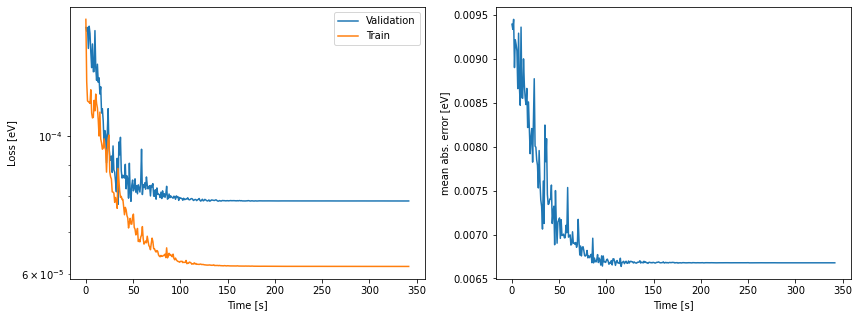

In [306]:
import numpy as np
import matplotlib.pyplot as plt
from ase.units import kcal, mol

results = np.loadtxt(os.path.join(model_dir, 'log.csv'), skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final validation MAE:', np.round(val_mae[-1], 4), 'eV =',
      np.round(val_mae[-1] / (kcal/mol), 4), 'kcal/mol')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, val_loss, label='Validation')
plt.plot(time, train_loss, label='Train')
plt.yscale('log')
plt.ylabel('Loss [eV]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae)
plt.ylabel('mean abs. error [eV]')
plt.xlabel('Time [s]')
plt.show()

In [307]:
import torch
best_model = torch.load('AgPd_Schnet/best_model')

In [308]:
test_loader = spk.AtomsLoader(test, batch_size=1, shuffle=True)


In [309]:
energy_targ = []
energy_pred = []

for batch in test_loader:
    test_batch = {k: v.to(device) for k, v in batch.items()}
    
    energy_targ.append(test_batch['energy'].detach().cpu().numpy())
    energy_pred.append(best_model(test_batch)['energy'].detach().cpu().numpy())

In [310]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#003f5c
#58508d
#bc5090
#ff6361
#ffa600
N = 5
newcolors = []
newcolors.append((0,63,92))
newcolors.append((88,80,141)) 
newcolors.append((188,80,144)) 
newcolors.append((255,99,97)) 
newcolors.append((255,166,0)) 

newcolors_norm = []
for i in newcolors:
    curr = np.asarray(i)
    print(curr)
    curr = curr/255.0
    curr = tuple(curr)
    newcolors_norm.append(curr)

cmap_name = 'my_list'
newcmp = LinearSegmentedColormap.from_list(cmap_name,newcolors_norm)

[ 0 63 92]
[ 88  80 141]
[188  80 144]
[255  99  97]
[255 166   0]


In [311]:
#print(energy_pred.shape)
#print(energy_pred)

In [312]:
energy_pred = np.asarray(energy_pred).reshape(-1)
energy_targ = np.asarray(energy_targ).reshape(-1)

print(energy_pred.shape)
print(energy_targ.shape)

(62,)
(62,)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


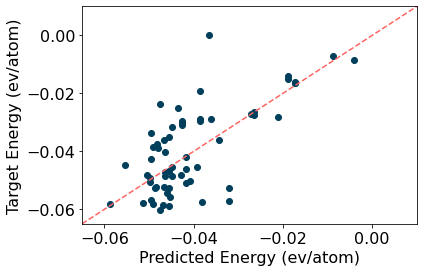

In [313]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Predicted Energy (ev/atom)',fontsize=16,fontname = "Arial")
plt.ylabel('Target Energy (ev/atom)',fontsize=16,fontname = "Arial")
plt.scatter(energy_pred,energy_targ,color=newcmp(0.0))
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.xlim(-0.065,0.01)
plt.ylim(-0.065,0.01)
x = np.linspace(-0.065,0.01,200)
plt.plot(x,x,color=newcmp(0.75),linestyle = '--')
plt.xticks([-0.06,-0.04,-0.02,0.0])
plt.yticks([-0.06,-0.04,-0.02,0.0])
plt.savefig('Schnet_test_final_submission.pdf',bbox_inches='tight')
plt.show()

In [314]:
print(np.mean(np.abs(energy_pred-energy_targ)))

0.008120309


In [315]:
np.std(energy_targ)

0.015083162

In [341]:
energy_targ = []
energy_pred = []
concs = []

for batch in train_loader:
    train_batch = {k: v.to(device) for k, v in batch.items()}
    
    energies = train_batch['energy'].detach().cpu().numpy().reshape(-1)
    atomic_ns = train_batch['_atomic_numbers'].detach().cpu().numpy()
    
    for i in range(atomic_ns.shape[0]):
        total = 0
        ag_count = 0
        for j in range(atomic_ns.shape[1]):
            if atomic_ns[i,j] == 47:
                ag_count +=1
                total+=1
            elif atomic_ns[i,j] == 46:
                total+=1
        concs.append(ag_count/total)
            
    preds = best_model(train_batch)['energy'].detach().cpu().numpy().reshape(-1)
    
    for i in range(energies.shape[0]):
    
        energy_targ.append(energies[i])
        energy_pred.append(preds[i])

In [342]:
for batch in val_loader:
    val_batch = {k: v.to(device) for k, v in batch.items()}
    
    energies = val_batch['energy'].detach().cpu().numpy().reshape(-1)
    atomic_ns = val_batch['_atomic_numbers'].detach().cpu().numpy()
    
    for i in range(atomic_ns.shape[0]):
        total = 0
        ag_count = 0
        for j in range(atomic_ns.shape[1]):
            if atomic_ns[i,j] == 47:
                ag_count +=1
                total+=1
            elif atomic_ns[i,j] == 46:
                total+=1
        concs.append(ag_count/total)
            
    preds = best_model(val_batch)['energy'].detach().cpu().numpy().reshape(-1)
    
    for i in range(energies.shape[0]):
    
        energy_targ.append(energies[i])
        energy_pred.append(preds[i])

In [343]:
for batch in test_loader:
    test_batch = {k: v.to(device) for k, v in batch.items()}
    
    energies = test_batch['energy'].detach().cpu().numpy().reshape(-1)
    atomic_ns = test_batch['_atomic_numbers'].detach().cpu().numpy()
    
    for i in range(atomic_ns.shape[0]):
        total = 0
        ag_count = 0
        for j in range(atomic_ns.shape[1]):
            if atomic_ns[i,j] == 47:
                ag_count +=1
                total+=1
            elif atomic_ns[i,j] == 46:
                total+=1
        concs.append(ag_count/total)
            
    preds = best_model(test_batch)['energy'].detach().cpu().numpy().reshape(-1)
    
    for i in range(energies.shape[0]):
    
        energy_targ.append(energies[i])
        energy_pred.append(preds[i])

In [364]:
energy_targ_np = np.asarray(energy_targ)
energy_pred_np = np.asarray(energy_pred)


In [365]:
print(np.mean(np.abs(energy_pred_np-energy_targ_np)))

0.007017472


In [391]:
for i in range(len(concs)):
    if concs[i] == 0:
        pd_energy = energy_pred[i]
        
    if concs[i]==1.0:
        ag_energy = energy_pred[i]

In [392]:
form_pred = []

for i in range(len(energy_pred)):
    new_form = energy_pred[i] - concs[i]*ag_energy - (1-concs[i])*pd_energy
    form_pred.append(new_form)

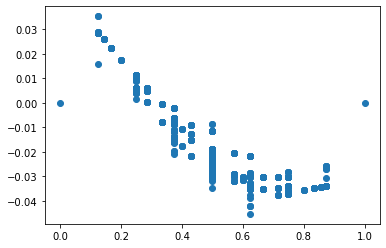

In [393]:
plt.scatter(concs,form_pred)
plt.show()